<a href="https://colab.research.google.com/github/akalexandrov/BioInformatics/blob/master/Burds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UCSD Birds Transfer Learning Notebook: Deep Tuning

This notebook is developed as a supplement to the talk titled "Transfer Learning: No Data? No Problem!" which can be found here: https://www.youtube.com/watch?v=1QeH0M8ommY.

This covers the CNN model tuning component of the transfer learning talk where we will first load up a model for training and change which parameters should be trainable and perform training on that. We also look at removing entire parts of the classifier layer and building a brand new one.

In [0]:
from collections import deque
from os import path
from statistics import mean
from time import time
from PIL import Image
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.models import alexnet, vgg16
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import torch

## Downloading data

In [0]:
if not path.exists('./CUB-200-2011-sc.zip'):
    !wget ahttps://syaffers-stuff.s3.amazonaws.com/datasets/CUB-200-2011-sc.zip
    !unzip CUB-200-2011-sc.zip > /dev/null

--2020-03-15 03:10:12--  https://syaffers-stuff.s3.amazonaws.com/datasets/CUB-200-2011-sc.zip
Resolving syaffers-stuff.s3.amazonaws.com (syaffers-stuff.s3.amazonaws.com)... 52.216.176.139
Connecting to syaffers-stuff.s3.amazonaws.com (syaffers-stuff.s3.amazonaws.com)|52.216.176.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162198721 (155M) [application/zip]
Saving to: ‘CUB-200-2011-sc.zip’

CUB-200-2011-sc.zip 100%[===================>] 154.68M  35.7MB/s    in 4.8s    

2020-03-15 03:10:18 (31.9 MB/s) - ‘CUB-200-2011-sc.zip’ saved [162198721/162198721]



## GPU execution

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Dataset and loaders

Heavy data augmentation is necessary here. See what you can do generate more artificial data on the fly.

In [0]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.3, 0.1, 0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_set = ImageFolder('CUB-200-2011/train', transform=train_transform)
valid_set = ImageFolder('CUB-200-2011/valid', transform=valid_transform)
test_set = ImageFolder('CUB-200-2011/test', transform=valid_transform)

In [0]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=128)
test_loader = DataLoader(test_set, batch_size=128)

## Model definition

We are retraining the last convolution layer (i.e. layer number 28) of the VGG network and training a totally new fully connected classifier. First, freeze the parameters of the CNN and enable the last convolution to be trainable and define a new classifier.

Feel free to try another network or fine tune more convolution layers.

In [0]:
model = vgg16(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

for param in model.features[28].parameters():
    param.requires_grad_()

model.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 200)
)

model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Training loop

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9, nesterov=True, weight_decay=0.0001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [10, 20], gamma=0.3)
num_epochs = 30

In [0]:
state = {
    'train_loss': [],
    'train_acc': [],
    'valid_loss': [],
    'valid_acc': []
}

train_losses = deque([], maxlen=len(train_loader))
train_accs = deque([], maxlen=len(train_loader))
valid_losses = deque([], maxlen=len(valid_loader))
valid_accs = deque([], maxlen=len(valid_loader))
best_loss = 1e9

start_time = time()
for e in tqdm_notebook(range(num_epochs)):
    model.train()
    for images, labels in tqdm_notebook(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output, labels)
        acc = torch.mean((output.argmax(dim=1) == labels).float())
        
        train_losses.append(loss.item())
        train_accs.append(acc.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            valid_loss = criterion(output, labels)
            valid_acc = torch.mean((output.argmax(dim=1) == labels).float())
            
            valid_losses.append(valid_loss.item())
            valid_accs.append(valid_acc.item())

        train_loss = mean(train_losses)
        train_acc = mean(train_accs)
        valid_loss = mean(valid_losses)
        valid_acc = mean(valid_accs)
        
        state['train_loss'].append(train_loss)
        state['train_acc'].append(train_acc)
        state['valid_loss'].append(valid_loss)
        state['valid_acc'].append(valid_acc)

        if valid_loss < best_loss:
            best_model_state = model.state_dict()
            best_loss = valid_loss

        print('[%03d] Train acc: %.4f Train loss: %.4f Valid acc: %.4f Valid loss: %.4f' %
              (e, train_acc, train_loss, valid_acc, valid_loss))
        print('Time elapsed', time() - start_time, 'seconds')
    
    scheduler.step()

[000] Train acc: 0.0786 Train loss: 4.6852 Valid acc: 0.2342 Valid loss: 3.3138
Time elapsed 104.89599418640137 seconds


[001] Train acc: 0.2856 Train loss: 3.0069 Valid acc: 0.4732 Valid loss: 2.1253
Time elapsed 209.98148345947266 seconds


[002] Train acc: 0.4404 Train loss: 2.2043 Valid acc: 0.5067 Valid loss: 1.8728
Time elapsed 315.3306791782379 seconds


[003] Train acc: 0.5267 Train loss: 1.7812 Valid acc: 0.5723 Valid loss: 1.6041
Time elapsed 420.10752749443054 seconds


[004] Train acc: 0.6014 Train loss: 1.4674 Valid acc: 0.5968 Valid loss: 1.4922
Time elapsed 524.8654882907867 seconds


[005] Train acc: 0.6501 Train loss: 1.2629 Valid acc: 0.5748 Valid loss: 1.5103
Time elapsed 629.7885565757751 seconds


[006] Train acc: 0.6930 Train loss: 1.0848 Valid acc: 0.5924 Valid loss: 1.5096
Time elapsed 734.5957992076874 seconds


[007] Train acc: 0.7330 Train loss: 0.9545 Valid acc: 0.6081 Valid loss: 1.4584
Time elapsed 839.4613778591156 seconds


[008] Train acc: 0.7509 Train loss: 0.8608 Valid acc: 0.6081 Valid loss: 1.3422
Time elapsed 943.6462049484253 seconds


[009] Train acc: 0.7773 Train loss: 0.7721 Valid acc: 0.6259 Valid loss: 1.3678
Time elapsed 1048.6255009174347 seconds


[010] Train acc: 0.8301 Train loss: 0.5994 Valid acc: 0.6493 Valid loss: 1.2677
Time elapsed 1153.606011390686 seconds


[011] Train acc: 0.8467 Train loss: 0.5401 Valid acc: 0.6459 Valid loss: 1.3148
Time elapsed 1258.4966809749603 seconds


[012] Train acc: 0.8583 Train loss: 0.4982 Valid acc: 0.6438 Valid loss: 1.2554
Time elapsed 1363.4478328227997 seconds


[013] Train acc: 0.8714 Train loss: 0.4588 Valid acc: 0.6571 Valid loss: 1.2702
Time elapsed 1468.320387840271 seconds


[014] Train acc: 0.8699 Train loss: 0.4470 Valid acc: 0.6538 Valid loss: 1.2653
Time elapsed 1572.7774062156677 seconds


[015] Train acc: 0.8833 Train loss: 0.4131 Valid acc: 0.6483 Valid loss: 1.2684
Time elapsed 1677.349502325058 seconds


[016] Train acc: 0.8843 Train loss: 0.3978 Valid acc: 0.6738 Valid loss: 1.2264
Time elapsed 1781.996237039566 seconds


[017] Train acc: 0.8919 Train loss: 0.3779 Valid acc: 0.6827 Valid loss: 1.2305
Time elapsed 1886.6902799606323 seconds


[018] Train acc: 0.8978 Train loss: 0.3522 Valid acc: 0.6681 Valid loss: 1.2366
Time elapsed 1991.5226080417633 seconds


[019] Train acc: 0.8934 Train loss: 0.3572 Valid acc: 0.6693 Valid loss: 1.2344
Time elapsed 2096.669390439987 seconds


[020] Train acc: 0.9095 Train loss: 0.3179 Valid acc: 0.6715 Valid loss: 1.2270
Time elapsed 2202.00728058815 seconds


[021] Train acc: 0.9174 Train loss: 0.2994 Valid acc: 0.6793 Valid loss: 1.2376
Time elapsed 2307.234248638153 seconds


[022] Train acc: 0.9129 Train loss: 0.3092 Valid acc: 0.6782 Valid loss: 1.2195
Time elapsed 2412.043763399124 seconds


[023] Train acc: 0.9204 Train loss: 0.2830 Valid acc: 0.6726 Valid loss: 1.2192
Time elapsed 2516.527595281601 seconds


[024] Train acc: 0.9245 Train loss: 0.2729 Valid acc: 0.6771 Valid loss: 1.2217
Time elapsed 2621.368401527405 seconds


[025] Train acc: 0.9188 Train loss: 0.2866 Valid acc: 0.6849 Valid loss: 1.2207
Time elapsed 2726.2097499370575 seconds


[026] Train acc: 0.9197 Train loss: 0.2795 Valid acc: 0.6760 Valid loss: 1.2344
Time elapsed 2831.173753976822 seconds


[027] Train acc: 0.9234 Train loss: 0.2797 Valid acc: 0.6760 Valid loss: 1.2319
Time elapsed 2936.289178133011 seconds


[028] Train acc: 0.9262 Train loss: 0.2626 Valid acc: 0.6782 Valid loss: 1.2354
Time elapsed 3041.566240310669 seconds


[029] Train acc: 0.9279 Train loss: 0.2610 Valid acc: 0.6838 Valid loss: 1.2357
Time elapsed 3147.243898630142 seconds



## Saving and visualization

We save a bunch of information in a Python dictionary. Among other information like the training and validation metrics is the checkpointed weights of the neural net. This is what you will load back into the model at test time to do prediction.

In [0]:
state['checkpoint'] = best_model_state
torch.save(state, '/content/drive/My Drive/Presentation Stuff/vgg16_v2.pt')

Have a look at the plots. In my book, as long as your **validation** loss is going down, your model is training well. Don't worry too much about the training loss/accuracy too much.

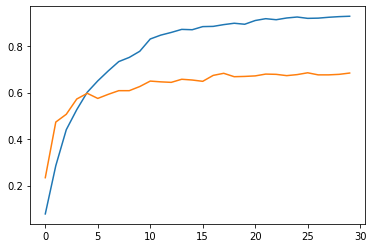

In [0]:
plt.plot(state['train_acc'])
plt.plot(state['valid_acc'])

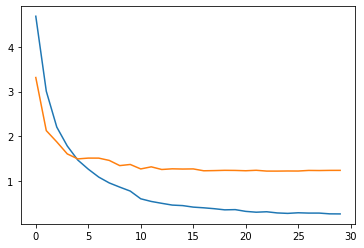

In [0]:
plt.plot(state['train_loss'])
plt.plot(state['valid_loss'])

## Testing

We have to rebuild our model if we load the notebook from scratch, here's all the code for reference, we don't actually need to do this since our model is already in the right architecture from the training portion of this notebook. However, you'll need to remember the architecture. _Do this wrong and you might end up with a big error with no way of finding out what's not loading properly_.

Always remember to have `model.eval()` on. Try removing it and running the code. Did your accuracy lower?

In [0]:
model = vgg16(pretrained=True)

model.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 200)
)

model.eval()
model.to(device)
model.load_state_dict(best_model_state)

test_losses = []
test_accs = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        test_loss = criterion(output, labels)
        test_acc = torch.mean((output.argmax(dim=1) == labels).float())
        
        test_losses.append(test_loss.item())
        test_accs.append(test_acc.item())

print(mean(test_losses))
print(mean(test_accs))

1.06323933750391
0.7140625
